### Classification: video frame size

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
from IPython.display import *
import cv2
from fastai.core import *
from fastai.vision import *
from facenet_pytorch import MTCNN
from kgl_deepfake.nb_00 import *
from kgl_deepfake.nb_01b import *
from kgl_deepfake.nb_03 import *

In [ ]:
torch.multiprocessing.set_start_method('spawn')

In [ ]:
SOURCE = Path('../data/train_sample_videos/')

In [ ]:
f = get_files(SOURCE, extensions=['.json'])[0]
annots = pd.read_json(f).T
annots.reset_index(inplace=True)
annots.rename({'index':'fname'}, axis=1, inplace=True)

In [ ]:
mtcnn_defaults = dict(device='cuda:0' if torch.cuda.is_available() else 'cpu',
                      post_process=False, select_largest=False)
mtcnn_defaults

{'device': 'cuda:0', 'post_process': False, 'select_largest': False}

In [ ]:
def get_data(bs=32, sz=224, margin=0, resize=.5):
    detector = MTCNN(margin=margin, image_size=sz, **mtcnn_defaults)
    src = (VideoFaceList
           .from_df(df=annots, path=SOURCE, cols='fname', 
                    detector=detector, resize=resize, equalize=True)
           .split_by_rand_pct())
    data = (src.label_from_df('label')
            .transform(get_transforms(), size=sz)
            .databunch(bs=bs, num_workers=4)
            .normalize(imagenet_stats))
    return data

### `resize = None`.  original size

In [ ]:
resize = None

In [ ]:
data = get_data(resize=resize)
model = MesoNet()

CPU times: user 40.7 s, sys: 15.1 s, total: 55.8 s
Wall time: 7.38 s


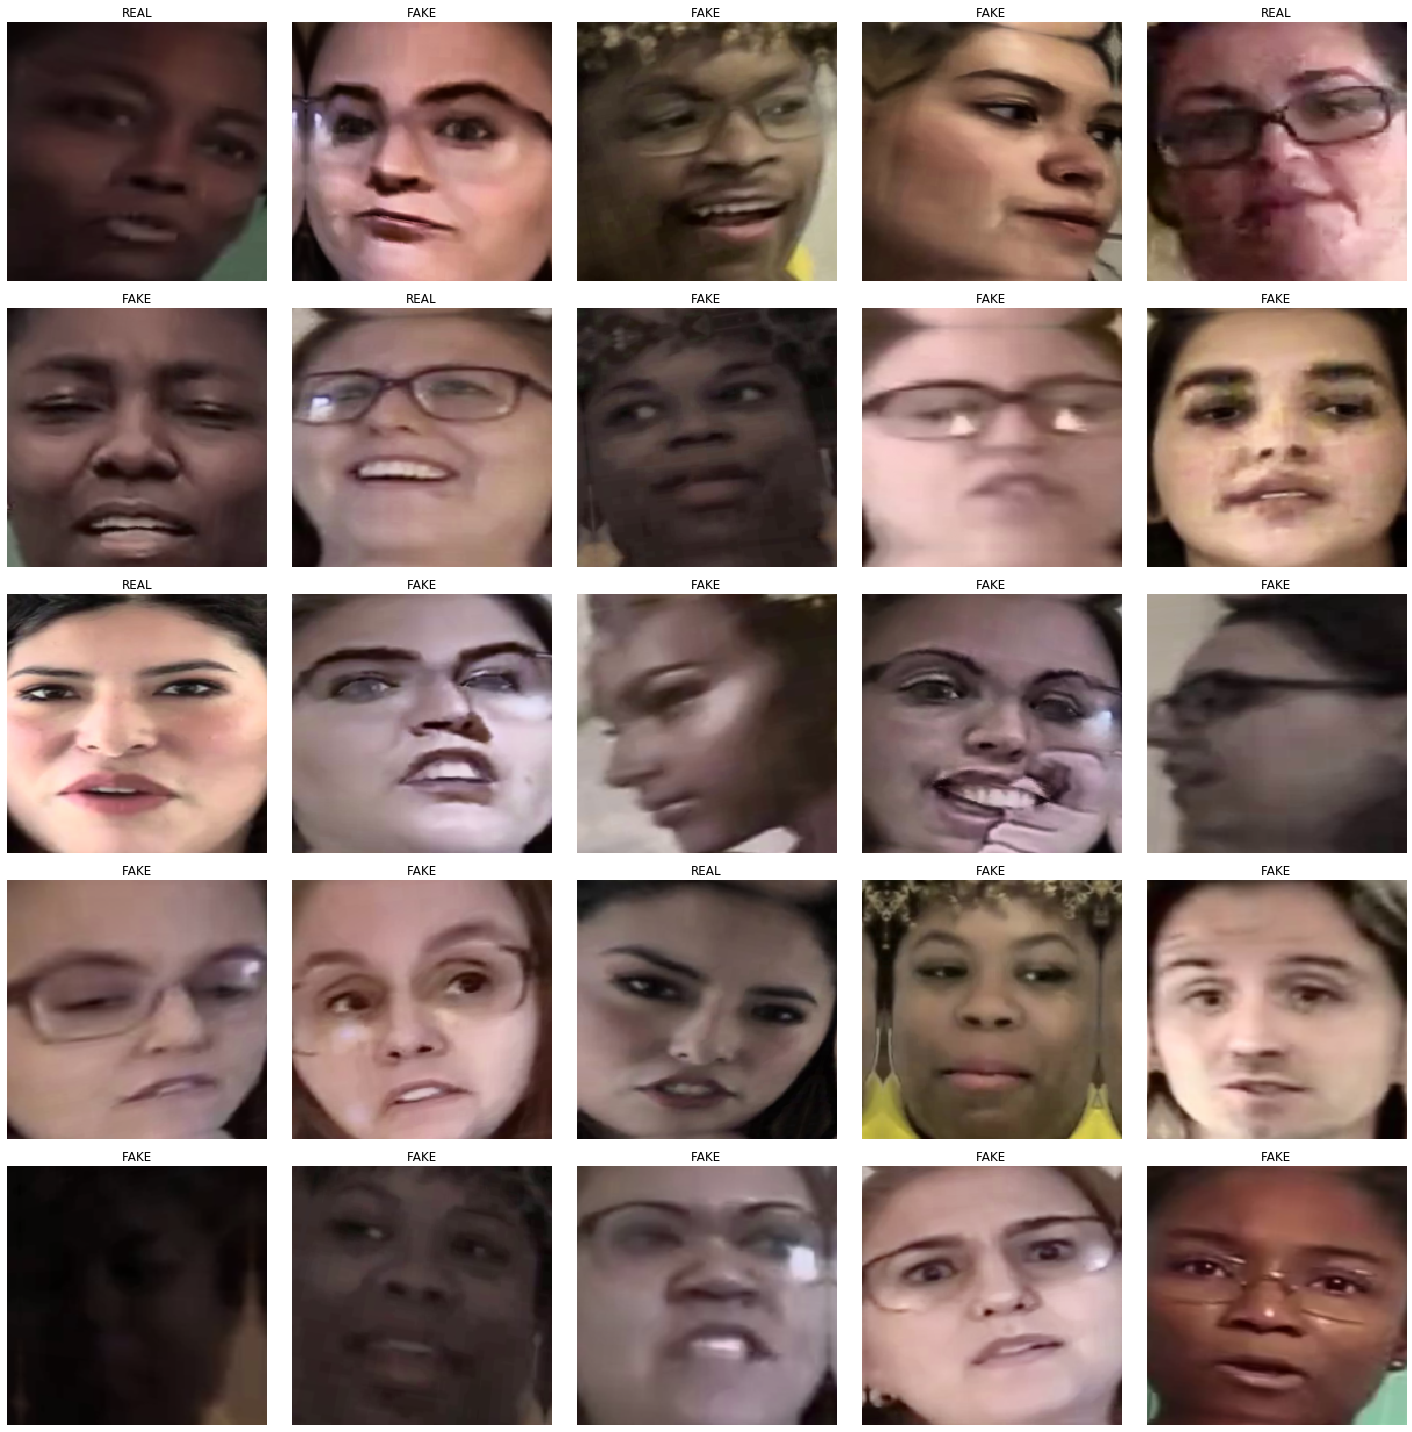

In [ ]:
%%time
data.show_batch()

In [ ]:
data.train_ds.x

VideoFaceList (320 items)
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
Path: ../data/train_sample_videos

In [ ]:
learn = Learner(data, model, metrics=accuracy).to_fp16()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


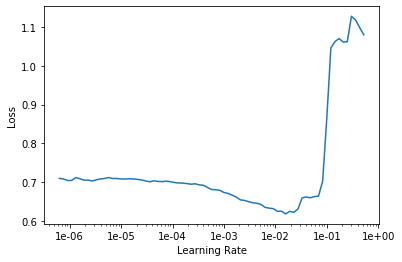

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(cyc_len=10, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.715182,0.680928,0.650000,00:52
1,0.649761,0.614331,0.737500,00:52
2,0.599872,0.605595,0.762500,00:52
3,0.578688,0.533408,0.787500,00:51
4,0.559532,0.581300,0.825000,00:52
5,0.554508,0.516036,0.812500,00:52
6,0.539740,0.520288,0.800000,00:52
7,0.529233,0.534724,0.800000,00:51
8,0.520993,0.567142,0.787500,00:52
9,0.512777,0.518051,0.812500,00:51


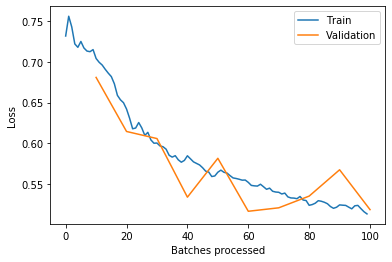

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save(f'mesonet_margin0_resize{resize}_equalizeTrue')

In [ ]:
learn.load(f'mesonet_margin0_resize{resize}_equalizeTrue');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

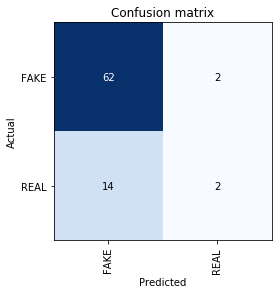

In [ ]:
interp.plot_confusion_matrix()